In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
import torch
from transformers import EvalPrediction

c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = load_dataset('rootblind/opjustice_side-model-dataset', split='train')
test_dataset = load_dataset('rootblind/opjustice_side-model-dataset', split='test')

df_train = train_dataset.to_pandas()
df_test = test_dataset.to_pandas()

Repo card metadata block was not found. Setting CardData to empty.
Generating test split: 100%|██████████| 2528/2528 [00:00<00:00, 184918.04 examples/s]
Repo card metadata block was not found. Setting CardData to empty.


In [3]:
df_train.head()

,Message,OK,NOT OK
0,In urm 7 zile,1,0
1,AM DAT SKIP LA PROMO,1,0
2,sunt flex warriors,1,0
3,Foarte sntos,1,0
4,uitel coaie,1,0


In [4]:
df_test.head()

,Message,OK,NOT OK
0,ce sati faca adminii,1,0
1,BAAAGAMIAS PULS GEAMU LA MASINA,1,0
2,mia aratat nudes in privat cum a promis,1,0
3,Ce buna era,1,0
4,neee,1,0


In [5]:
df_train.describe()

,OK,NOT OK
count,10113.000000,10113.000000
mean,0.526451,0.473549
std,0.499325,0.499325
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10113 entries, 0 to 10112
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Message  10113 non-null  object
 1   OK       10113 non-null  int64 
 2   NOT OK   10113 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 237.2+ KB


In [7]:
df_train.isnull().sum()

Message    0
OK         0
NOT OK     0
dtype: int64

In [8]:
print('Train shape: ', str(df_train.shape))
print('Test shape: ', str(df_test.shape))

Train shape:  (10113, 3)
Test shape:  (2528, 3)


In [9]:
print(f'Number of duplicated instances in train: {df_train.duplicated().sum()}')
print(f'Number of duplicated instances in test: {df_test.duplicated().sum()}')

Number of duplicated instances in train: 158
Number of duplicated instances in test: 9


In [10]:
numeric_df = df_train.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

         OK  NOT OK
OK      1.0    -1.0
NOT OK -1.0     1.0


In [11]:
# calling the vectorizer to encode the announcements
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['Message'])
y_train = df_train.drop(columns='Message')
print(X_train.shape)

(10113, 24887)


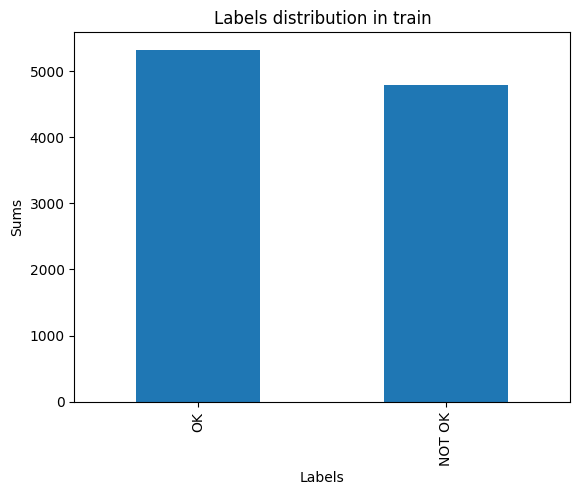

OK        5324
NOT OK    4789
dtype: int64


In [12]:
columns = df_train.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in train')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

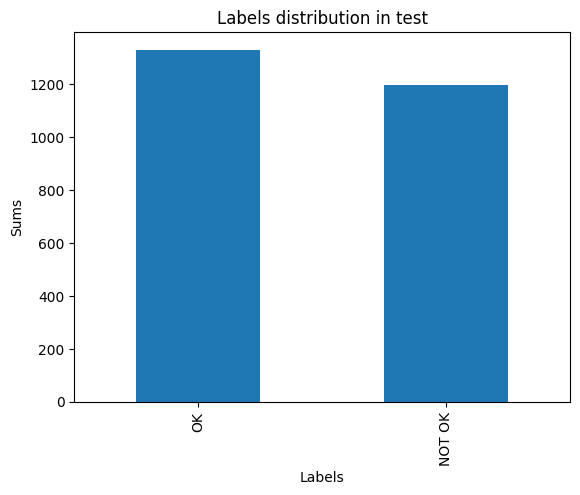

OK        1331
NOT OK    1197
dtype: int64


In [13]:
columns = df_test.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in test')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

<Axes: >

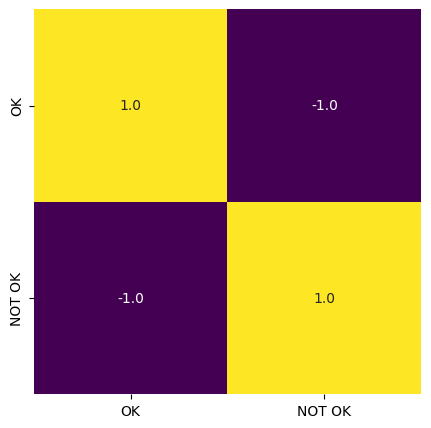

In [14]:
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cbar=None,cmap='viridis')

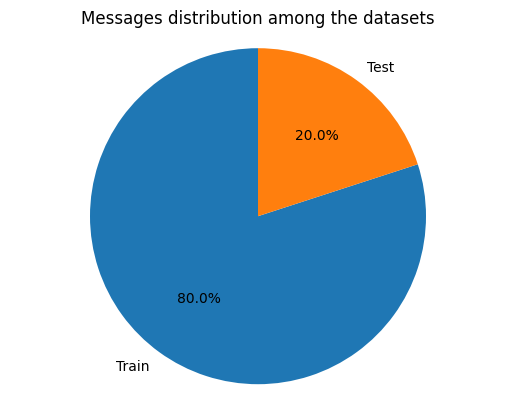

[10113, 2528]


In [15]:
train_test = ['Train', 'Test']
train_test_size = [df_train['Message'].value_counts().sum(), df_test['Message'].value_counts().sum()]
plt.pie(train_test_size, labels=train_test, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Messages distribution among the datasets')
plt.show()
print(train_test_size)

## Other models performance on my dataset

In [16]:
X_test = vectorizer.transform(df_test['Message'])
y_test = df_test.drop(columns='Message')

X_test.shape

(2528, 24887)

In [17]:
X_train.shape

(10113, 24887)

In [18]:
model = OneVsRestClassifier(RandomForestClassifier())
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier())

In [19]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1331
           1       0.80      0.81      0.80      1197

   micro avg       0.81      0.81      0.81      2528
   macro avg       0.81      0.81      0.81      2528
weighted avg       0.81      0.81      0.81      2528
 samples avg       0.80      0.81      0.80      2528



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
model = OneVsRestClassifier(GaussianNB())
model.fit(X_train.toarray(), y_train)

OneVsRestClassifier(estimator=GaussianNB())

In [21]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1331
           1       0.84      0.83      0.83      1197

   micro avg       0.84      0.84      0.84      2528
   macro avg       0.84      0.84      0.84      2528
weighted avg       0.84      0.84      0.84      2528
 samples avg       0.84      0.84      0.84      2528



In [22]:
model = OneVsRestClassifier(DecisionTreeClassifier())
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier())

In [23]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1331
           1       0.72      0.78      0.75      1197

   micro avg       0.75      0.75      0.75      2528
   macro avg       0.75      0.75      0.75      2528
weighted avg       0.75      0.75      0.75      2528
 samples avg       0.74      0.75      0.74      2528



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
model = OneVsRestClassifier(LogisticRegression())
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [25]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1331
           1       0.86      0.82      0.84      1197

   micro avg       0.85      0.85      0.85      2528
   macro avg       0.85      0.85      0.85      2528
weighted avg       0.85      0.85      0.85      2528
 samples avg       0.85      0.85      0.85      2528



## My model

In [26]:
class ToxicityDataset:
    def __init__(self, dataset_path='./automod-model/side-model/dataset', dataset_name='rootblind/opjustice_side-model-dataset'):
        self.dataset_path = dataset_path
        self.dataset_name = dataset_name
        self.dataset = self.load_dataset()
        self.labels = self.get_labels()
        self.id2label, self.label2id = self.create_label_mappings()

    def load_dataset(self):
        dataset = load_dataset(self.dataset_name)
        return dataset

    def get_labels(self):
        return [label for label in self.dataset['train'].features.keys() if label not in 'Message']

    def create_label_mappings(self):
        id2label = {idx: label for idx, label in enumerate(self.labels)}
        label2id = {label: idx for idx, label in enumerate(self.labels)}
        return id2label, label2id

    def preprocess_data(self, examples, tokenizer):
        text = examples["Message"]
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=400)
        labels_batch = {k: examples[k] for k in examples.keys() if k in self.labels}
        labels_matrix = np.zeros((len(text), len(self.labels)))

        for idx, label in enumerate(self.labels):
            labels_matrix[:, idx] = labels_batch[label]

        encoding["labels"] = labels_matrix.tolist()
        return encoding

    def encode_dataset(self, tokenizer):
        encoded_dataset = self.dataset.map(lambda x: self.preprocess_data(x, tokenizer), batched=True, remove_columns=self.dataset['train'].column_names)
        encoded_dataset.set_format("torch")
        return encoded_dataset

In [27]:
class ToxicityModel:
    def __init__(self, model_name, num_labels, id2label, label2id, device=None):
        self.model_name = model_name
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.load_model(num_labels, id2label, label2id)

    def load_model(self, num_labels, id2label, label2id):
        model = AutoModelForSequenceClassification.from_pretrained(self.model_name, 
                                                                   problem_type="multi_label_classification", 
                                                                   num_labels=num_labels,
                                                                   id2label=id2label,
                                                                   label2id=label2id).to(self.device)
        
        return model

    def predict(self, text, tokenizer):
        encoding = tokenizer(text, return_tensors="pt")
        encoding = {k: v.to(self.device) for k, v in encoding.items()}
        with torch.no_grad():
            outputs = self.model(**encoding)
        
        logits = outputs.logits
        softmax = torch.nn.Softmax()
        probs = softmax(logits.squeeze().cpu())
        predictions = np.zeros(probs.shape)
        predictions[np.argmax(probs)] = 1
        return predictions

In [28]:
toxicityDataset = ToxicityDataset()
toxicityModel = ToxicityModel(
    model_name='./model_versions/v1-fold-1',
    num_labels=len(toxicityDataset.labels),
    id2label=toxicityDataset.id2label,
    label2id=toxicityDataset.label2id
    
    )

Repo card metadata block was not found. Setting CardData to empty.


In [29]:
tokenizer = AutoTokenizer.from_pretrained('readerbench/RoBERT-base')
loaded_dataset = toxicityDataset.load_dataset()
encoded_dataset = toxicityDataset.encode_dataset(tokenizer)

Repo card metadata block was not found. Setting CardData to empty.
Map: 100%|██████████| 2528/2528 [00:00<00:00, 5874.57 examples/s]


In [30]:
X_test = [sample['Message'] for sample in loaded_dataset['test']]
y_test = [[sample[label] for label in toxicityDataset.labels] for sample in loaded_dataset['test']]

In [31]:
y_pred = [toxicityModel.predict(text, tokenizer) for text in X_test]

c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [32]:
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

F1 Score: 0.9548674181990888
Precision: 0.955137534103445
Recall: 0.9549050632911392
Accuracy: 0.9549050632911392
ROC AUC: 0.9541051476675662


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, y_pred)

array([[[1124,   73],
        [  41, 1290]],

       [[1290,   41],
        [  73, 1124]]], dtype=int64)